In [1]:
#import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import collections
from scipy.optimize import curve_fit

In [3]:
import pandas as pd
df=pd.read_csv('data/oilDB.csv',sep=',')
df.head()

,exp,imp,v
0,Afghanistan,Paraguay,2667.523
1,Albania,Bulgaria,1317.288
2,Albania,Czechia,10834.733
3,Albania,Egypt,9352.174
4,Albania,Greece,41345.449


In [5]:
dG=nx.from_pandas_edgelist(df,'exp','imp',['v'],create_using=nx.DiGraph())

On transforme en graphe non dirigé où les poids sont égaux à la somme des valeurs $v$

In [6]:
G=nx.to_undirected(dG)
for (i,j) in G.edges():
    G[i][j]['weight']=0
    if (i,j) in dG.edges():
        G[i][j]['weight']=G[i][j]['weight']+dG[i][j]['v']
    if (j,i) in dG.edges():
        G[i][j]['weight']=G[i][j]['weight']+dG[j][i]['v']

In [7]:
list(G.edges(data=True))[:5]

[('Afghanistan', 'Belarus', {'v': 29631.6, 'weight': 29631.6}),
 ('Afghanistan',
  'Kazakhstan',
  {'v': 128145.51199999999, 'weight': 128145.51199999999}),
 ('Afghanistan',
  'Turkmenistan',
  {'v': 66452.41900000001, 'weight': 66452.41900000001}),
 ('Afghanistan', 'Russian Federation', {'v': 40907.138, 'weight': 40907.138}),
 ('Afghanistan', 'Uzbekistan', {'v': 173777.108, 'weight': 173777.108})]

In [11]:
list(G.edges(data="weight"))

[('Afghanistan', 'Belarus', 29631.6),
 ('Afghanistan', 'Kazakhstan', 128145.51199999999),
 ('Afghanistan', 'Turkmenistan', 66452.41900000001),
 ('Afghanistan', 'Russian Federation', 40907.138),
 ('Afghanistan', 'Uzbekistan', 173777.108),
 ('Afghanistan', 'Azerbaijan', 72687.057),
 ('Afghanistan', 'Pakistan', 164780.95299999998),
 ('Afghanistan', 'Paraguay', 2667.523),
 ('Afghanistan', 'Spain', 1939.356),
 ('Afghanistan', 'Iran', 658642.0929999999),
 ('Afghanistan', 'United Arab Emirates', 38082.609),
 ('Paraguay', 'Netherlands', 389106.544),
 ('Paraguay', 'Bolivia (Plurinational State of)', 60343.12299999999),
 ('Paraguay', 'Germany', 1200.382),
 ('Paraguay', 'Algeria', 1246.862),
 ('Paraguay', 'Switzerland', 45012.17000000001),
 ('Paraguay', 'Argentina', 686680.741),
 ('Paraguay', 'Mexico', 6795.1280000000015),
 ('Paraguay', 'Panama', 96408.35),
 ('Paraguay', 'Colombia', 2349.393),
 ('Paraguay', 'Brazil', 1710618.282),
 ('Paraguay', 'Peru', 2205.02),
 ('Paraguay', 'United Arab Emirate

In [8]:
nx.density(G)

0.17997716991502136

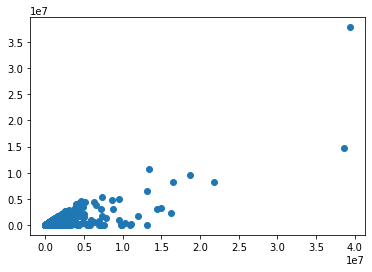

In [23]:
x = [G[u][v]['weight'] for (u,v) in G.edges()]
y = [G[u][v]['v'] for (u,v) in G.edges()]
plt.scatter(x,y)

# Weight's distribution

In [14]:
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins,density=True)
    logBins = np.delete(logBins, -1)
    return logBinDensity, logBins

In [15]:
weights=[G[u][v]['weight'] for (u,v) in G.edges()]

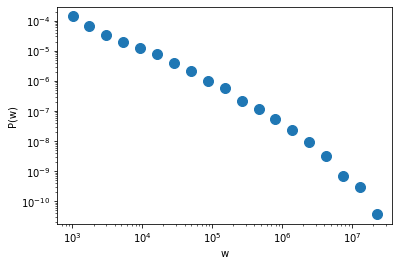

In [16]:
y,x=logBinning(np.array(weights),20)
plt.loglog(x,y,'o',markersize=10)
plt.xlabel('w')
plt.ylabel('P(w)')
plt.show()

# Strength distribution

In [17]:
s=list(dict(G.degree(weight='weight')).values())

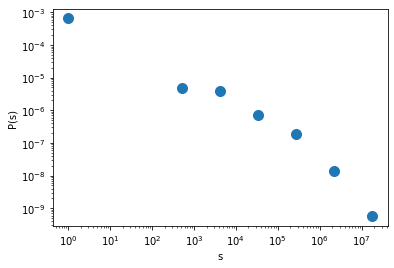

In [18]:
y,x=logBinning(np.array(s),10)
plt.loglog(x,y,'o',markersize=10)
plt.xlabel('s')
plt.ylabel('P(s)')
plt.show()

# Strength degree correlation

In [19]:
k=list(dict(G.degree()).values())

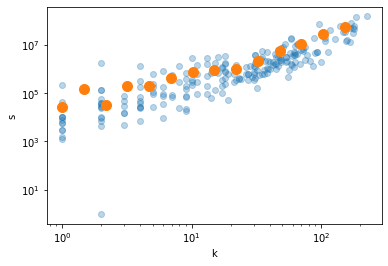

In [20]:
plt.loglog(k,s,'o',alpha=0.3)

logBins=np.logspace(np.log2(np.min(k)),np.log2(np.max(k)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(k,s,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10)

plt.xlabel('k')
plt.ylabel('s')
plt.show()

In [25]:
def powerLaw(x, a, b):
    return b*x**(a)

1.3063774375245327


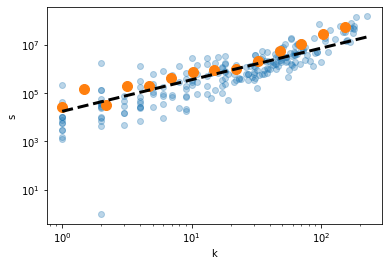

In [26]:
#Graphique
plt.loglog(k,s,'o',alpha=0.3)

logBins=np.logspace(np.log2(np.min(k)),np.log2(np.max(k)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(k,s,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10)

# Fit : Elle propose de le faire jusqu'à 50 pour voir si ça marche bien
fitx=[i for (i,j) in zip(k,s) if  i<50]
fity=[j for (i,j) in zip(k,s) if i<50]
popt, pcov = curve_fit(powerLaw, fitx, fity)  
#popt, pcov = curve_fit(powerLaw, k, s)  
print (popt[0]) # 1.3 >1 : les noeuds qui ont un degré plus élevé sont associé à des points plus importants
# C'est bien normal : la pondération est associée à la structure topologique
plt.loglog(sorted(k), powerLaw(sorted(k), *popt), '--',c='k',linewidth=3)

plt.xlabel('k')
plt.ylabel('s')
plt.show()

# ROBUSTNESS

### random failures

In [37]:
fList=np.linspace(0,1,21) # 21 pour 5 % des noeuds
NtoRem=[int(i*G.number_of_nodes()) for i in fList]

In [38]:
print(NtoRem)

[0, 10, 21, 32, 43, 54, 65, 76, 87, 98, 109, 119, 130, 141, 152, 163, 174, 185, 196, 207, 218]


In [34]:
import random
sf=[]
for nn in NtoRem[:-1]:
    thisG=G.copy() # recopie le graph
    ll=random.sample(G.nodes(),nn) # SRS de ces noeuds
    thisG.remove_nodes_from(ll)
    # On prend la composante la plus grande et on prend sa taille
    thisSf=len(max(sorted(nx.connected_components(thisG), key = len, reverse=True)))
    sf.append(thisSf/float(G.number_of_nodes()))



### attacks
attaques ciblées : on enlève noeuds qui ont un degré le plus important.
Il faut réfléchir plus sur un réseau dirigé

In [39]:
hh=collections.Counter(dict(G.degree())).most_common()
orderedNodes=[u for (u,v) in hh] # on trie les noeuds selon le degré

In [40]:
print(orderedNodes[:10])

['USA', 'China', 'Netherlands', 'France', 'Germany', 'Russian Federation', 'Belgium', 'Italy', 'Turkey', 'United Arab Emirates']


On fait comme avant on prend 5 %

In [41]:
fList1=np.linspace(0,1,20)
NtoRem=[int(i*G.number_of_nodes()) for i in fList1]

In [42]:
sfAtt=[]
for nn in NtoRem[:-1]:
    thisG=G.copy()
    ll=orderedNodes[:nn] # on prend les premiers nn, on les enlèves
    thisG.remove_nodes_from(ll)
    thisSf=len(max(sorted(nx.connected_components(thisG), key = len, reverse=True)))
    sfAtt.append(thisSf/float(G.number_of_nodes()))

attaques ciblées bien plus efficaces

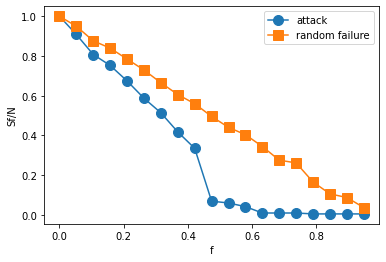

In [101]:
plt.plot(fList1[:-1],sfAtt,'o-',markerSize=10,label='attack')
plt.plot(fList[:-1],sf,'s-',markerSize=10,label='random failure')
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.legend()
plt.show()